In [1]:
!pip install astropy --upgrade
!pip install photutils

import numpy as np
import math
import matplotlib.pyplot as plt
import os
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
import glob
import warnings
warnings.filterwarnings("ignore")
from matplotlib.gridspec import GridSpec


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [191]:
bias_list = glob.glob('C:/Users/jimmy/OneDrive/Astron100/Day1/Bias/*BIAS*.fits')

science_list = glob.glob('C:/Users/jimmy/OneDrive/Astron100/Day1/Science/*0049.RXJ*.fits')

flat_list = glob.glob('C:/Users/jimmy/OneDrive/Astron100/Day1/Flats/*FLAT*.fits')

print(bias_list)
print(flat_list)
print(science_list)

['C:/Users/jimmy/OneDrive/Astron100/Day1/Bias\\0001.BIAS.fits', 'C:/Users/jimmy/OneDrive/Astron100/Day1/Bias\\0002.BIAS.fits', 'C:/Users/jimmy/OneDrive/Astron100/Day1/Bias\\0003.BIAS.fits', 'C:/Users/jimmy/OneDrive/Astron100/Day1/Bias\\0004.BIAS.fits', 'C:/Users/jimmy/OneDrive/Astron100/Day1/Bias\\0005.BIAS.fits', 'C:/Users/jimmy/OneDrive/Astron100/Day1/Bias\\0006.BIAS.fits', 'C:/Users/jimmy/OneDrive/Astron100/Day1/Bias\\0007.BIAS.fits', 'C:/Users/jimmy/OneDrive/Astron100/Day1/Bias\\0008.BIAS.fits', 'C:/Users/jimmy/OneDrive/Astron100/Day1/Bias\\0009.BIAS.fits', 'C:/Users/jimmy/OneDrive/Astron100/Day1/Bias\\0010.BIAS.fits']
['C:/Users/jimmy/OneDrive/Astron100/Day1/Flats\\0011.FLAT.fits', 'C:/Users/jimmy/OneDrive/Astron100/Day1/Flats\\0012.FLAT.fits', 'C:/Users/jimmy/OneDrive/Astron100/Day1/Flats\\0013.FLAT.fits', 'C:/Users/jimmy/OneDrive/Astron100/Day1/Flats\\0014.FLAT.fits', 'C:/Users/jimmy/OneDrive/Astron100/Day1/Flats\\0015.FLAT.fits', 'C:/Users/jimmy/OneDrive/Astron100/Day1/Flats\\0

In [192]:
f = fits.getheader(science_list[0])
f["OBJECT"]

'RXJ0602.1p2828'

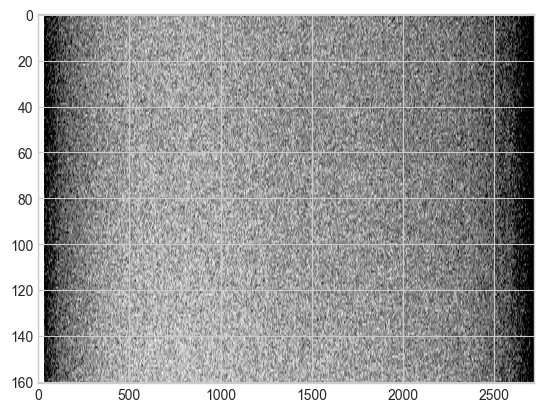

In [193]:
bias = glob.glob('C:/Users/jimmy/OneDrive/Astron100/Day1/Bias/*BIAS*.fits')

master_bias = []

for i in bias:
  data = fits.getdata(i)
  master_bias.append(data[None])

master_bias = np.concatenate(master_bias, axis = 0)
master_bias = np.median(master_bias, axis = 0)

plt.imshow(master_bias, vmax = np.percentile(master_bias, 90),
          vmin = np.percentile(master_bias, 5),
          aspect = 'auto')

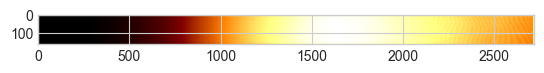

In [194]:
flats = glob.glob('C:/Users/jimmy/OneDrive/Astron100/Day1/Flats/*FLAT*.fits')

master_flat = []

for m in flats:
  data = fits.getdata(m)
  data = data - master_bias
  master_flat.append(data[None])

master_flat = np.concatenate(master_flat, axis = 0)
master_flat = np.median(master_flat, axis = 0)

plt.imshow(master_flat, vmax = np.percentile(master_flat, 99),
           vmin = np.percentile(master_flat, 10),
           cmap = 'afmhot')

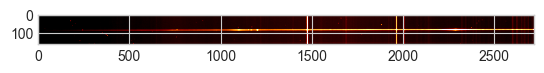

In [195]:
science = fits.getdata(science_list[0])

plt.imshow(science, vmax = np.percentile(science, 99),
           vmin = np.percentile(science, 10),
           cmap = 'afmhot')

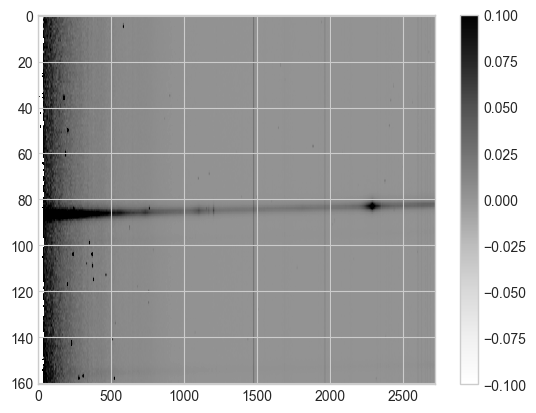

In [196]:
science = fits.getdata(science_list[0])
final = (science - master_bias) / master_flat

plt.imshow(final, vmax = np.percentile(final, 80),
          vmin = np.percentile(final, 25),
          aspect = 'auto')
plt.colorbar()

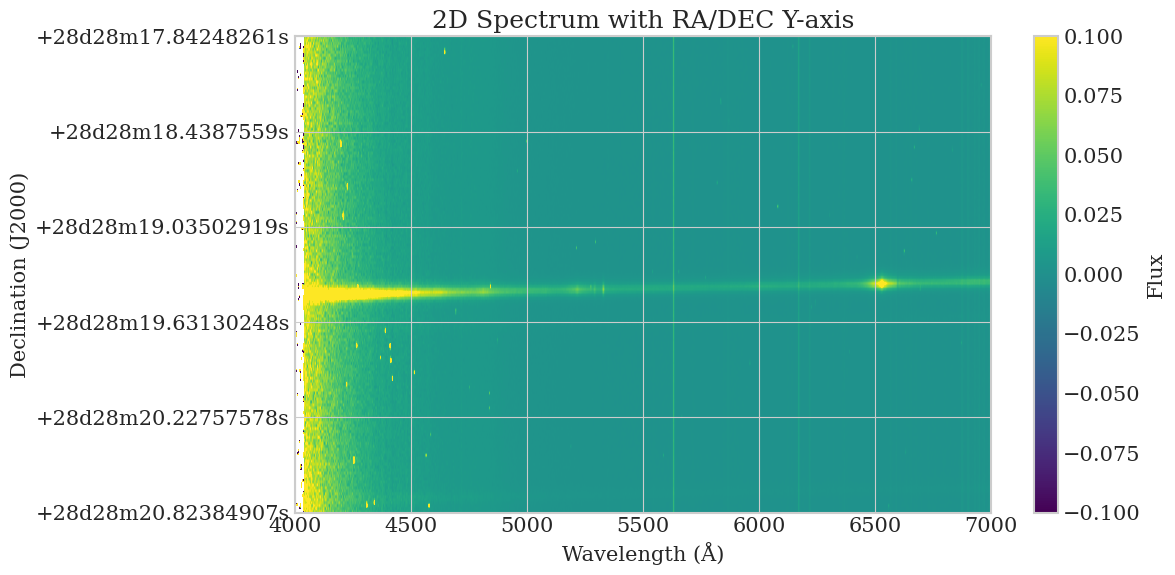

In [359]:
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.pyplot as plt
import numpy as np

ny, nx = final.shape
wavelengths = np.linspace(4000, 7000, nx)

# Slit info
slit_width_arcsec = 3.0
pixel_scale_arcsec = slit_width_arcsec / ny
ref_pixel = 84  # reference Y-pixel
arcsec_offset = (np.arange(ny) - ref_pixel) * pixel_scale_arcsec

# Define reference sky coordinate at pixel 84
ref_coord = SkyCoord(ra='06h02m10.47090', dec='+28d28m19.4077 s', frame='icrs')


# Convert arcsec offset to SkyCoord positions
dec_positions = ref_coord.dec + arcsec_offset * u.arcsec
ra_positions = np.full(dec_positions.shape, ref_coord.ra.deg) * u.deg  # ← FIXED

sky_coords = SkyCoord(ra=ra_positions, dec=dec_positions, frame='icrs')


# Select a few tick positions for labeling (e.g., every 20 pixels)
tick_indices = np.linspace(0, ny - 1, 6, dtype=int)
tick_labels = [sky_coords[i].to_string('hmsdms').split()[1] for i in tick_indices]  # DEC only

# Plot with RA/DEC axis
plt.figure(figsize=(12, 6))
plt.imshow(final, 
           aspect='auto', 
           extent=[wavelengths[0], wavelengths[-1], arcsec_offset[-1], arcsec_offset[0]],
           cmap='viridis',
           vmax=np.percentile(final, 90),
           vmin=np.percentile(final, 50))

plt.xlabel("Wavelength (Å)")
plt.ylabel("Declination (J2000)")
plt.yticks(arcsec_offset[tick_indices], tick_labels)  # Set custom y-axis ticks
plt.colorbar(label='Flux')
plt.title("2D Spectrum with RA/DEC Y-axis")
plt.tight_layout()


plt.rcParams['legend.frameon'] = True
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.labelspacing'] = 0.3
plt.rcParams['legend.handletextpad'] = 0.3
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'DejaVu Serif'
plt.rcParams['font.weight'] = 'light'
plt.rcParams['font.size'] = 15
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.width'] = 2
plt.rcParams["axes.linewidth"] = 1.5
plt.show()


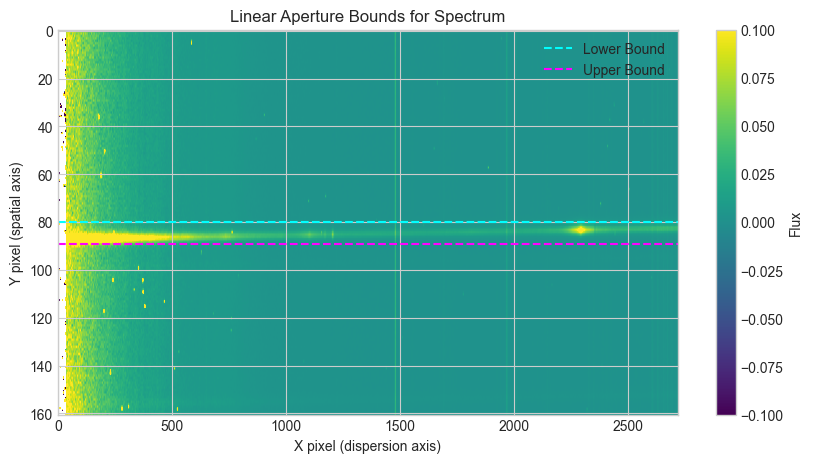

In [265]:
plt.figure(figsize=(10, 5))
plt.imshow(final, aspect='auto', cmap='viridis',
           vmin=np.percentile(final, 25), vmax=np.percentile(final, 80))
plt.axhline(80, color='cyan', linestyle='--', label='Lower Bound')
plt.axhline(89, color='magenta', linestyle='--', label='Upper Bound')
plt.legend()
plt.title("Linear Aperture Bounds for Spectrum")
plt.xlabel("X pixel (dispersion axis)")
plt.ylabel("Y pixel (spatial axis)")
plt.colorbar(label='Flux')
plt.show()

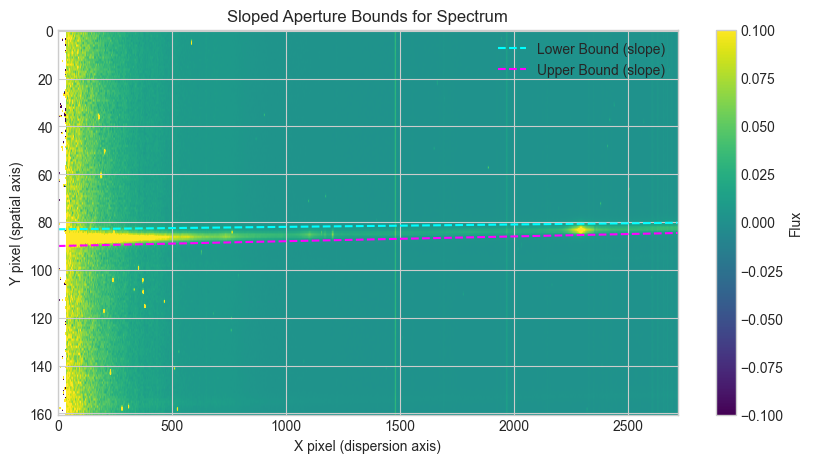

In [266]:
import numpy as np
import matplotlib.pyplot as plt

# Define x range for display (e.g., from column 600 to end)
x_start = 0
x_end = final.shape[1]
x_range = np.arange(x_start, x_end)

# Define slope + intercept for lower and upper bounds
lower_slope = -0.001
lower_intercept = 83
upper_slope = -0.002
upper_intercept = 90

# Calculate corresponding y-values for each x (your sloped bounds)
lower_bounds = lower_slope * x_range + lower_intercept
upper_bounds = upper_slope * x_range + upper_intercept

# Plot image and sloped bounds
plt.figure(figsize=(10, 5))
plt.imshow(final, aspect='auto', cmap='viridis',
           vmin=np.percentile(final, 25), vmax=np.percentile(final, 80))

# Overlay the sloped lines
plt.plot(x_range, lower_bounds, color='cyan', linestyle='--', label='Lower Bound (slope)')
plt.plot(x_range, upper_bounds, color='magenta', linestyle='--', label='Upper Bound (slope)')

plt.legend()
plt.title("Sloped Aperture Bounds for Spectrum")
plt.xlabel("X pixel (dispersion axis)")
plt.ylabel("Y pixel (spatial axis)")
plt.colorbar(label='Flux')
plt.show()


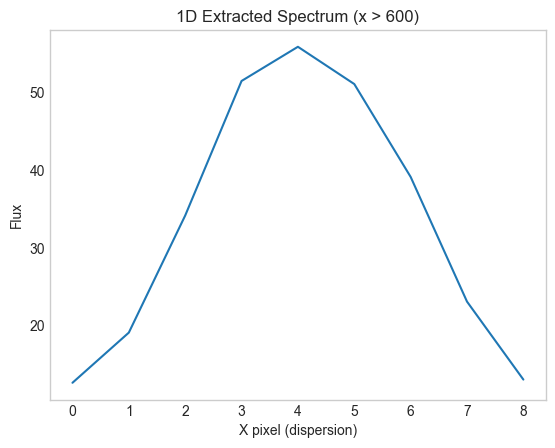

In [200]:
spectrum_1d_cropped = np.sum(final[80:89, 600:], axis=1)

plt.plot(spectrum_1d_cropped)
plt.title("1D Extracted Spectrum (x > 600)")
plt.xlabel("X pixel (dispersion)")
plt.ylabel("Flux")
plt.grid()
plt.show()

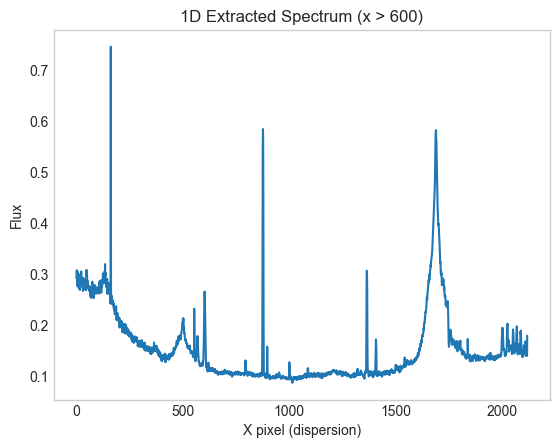

In [201]:
#spectrum_1d = np.sum(final[75:88, :], axis=0)

spectrum_1d_cropped = np.sum(final[75:88, 600:], axis=0)

plt.plot(spectrum_1d_cropped)
plt.title("1D Extracted Spectrum (x > 600)")
plt.xlabel("X pixel (dispersion)")
plt.ylabel("Flux")
plt.grid()
plt.show()

2120


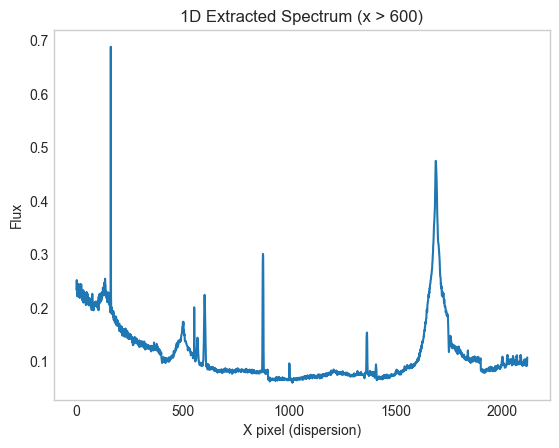

In [ ]:
import numpy as np

# Example: final is your 2D spectrum array
height, width = final.shape

# Define x range for display (e.g., from column 600 to end)
x_start = 600
x_end = final.shape[1]
x_range = np.arange(x_start, x_end)

# Define slope + intercept for lower and upper bounds
lower_slope = -0.001
lower_intercept = 83
upper_slope = -0.002
upper_intercept = 90

# Evaluate bounds for each x
lower_bounds = (lower_slope * x_range + lower_intercept).astype(int)
upper_bounds = (upper_slope * x_range + upper_intercept).astype(int)

# Ensure bounds are within array shape
lower_bounds = np.clip(lower_bounds, 0, height - 1)
upper_bounds = np.clip(upper_bounds, 0, height - 1)

# Sum pixels between bounds for each x
spectrum_1d_cropped = np.array([
    np.sum(final[lower:upper, x])
    for x, lower, upper in zip(x_range, lower_bounds, upper_bounds)
])

plt.plot(spectrum_1d_cropped)
plt.title("1D Extracted Spectrum (x > 600)")
plt.xlabel("X pixel (dispersion)")
plt.ylabel("Flux")
plt.grid()
plt.show()

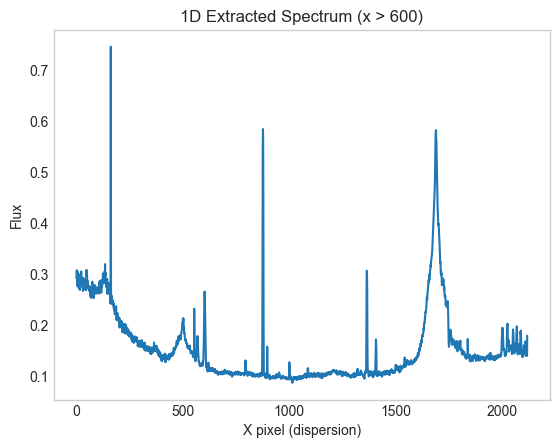

In [202]:
spectrum_1d = np.sum(final[75:88, :], axis=0)

plt.plot(spectrum_1d_cropped)
plt.title("1D Extracted Spectrum (x > 600)")
plt.xlabel("X pixel (dispersion)")
plt.ylabel("Flux")
plt.grid()
plt.show()

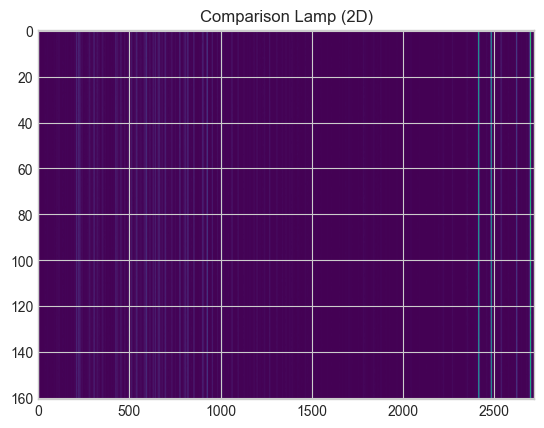

In [203]:
comp_path = 'C:/Users/jimmy/OneDrive/Astron100/Day1/Comp/0070.COMP_NGC4151.fits'
comp_data = fits.getdata(comp_path)

plt.imshow(comp_data, aspect='auto', cmap='viridis')
plt.title('Comparison Lamp (2D)')
plt.show()

In [204]:
fits.getheader(science_list[0])

ValueError: FITS header values must contain standard printable ASCII characters; "'28:28:19.4077\r    ' / DEC" contains characters not representable in ASCII or non-printable characters.

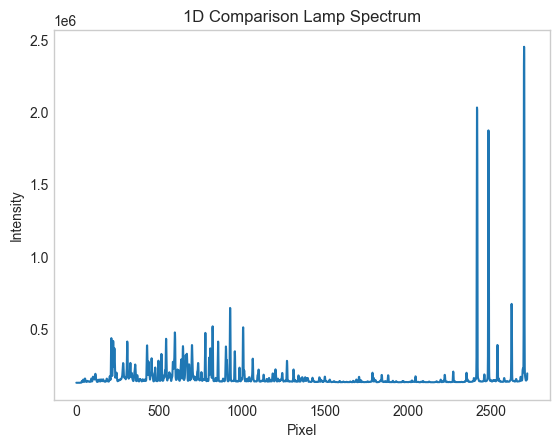

In [205]:
comp_spectrum_1d = np.sum(comp_data, axis=0)
plt.plot(comp_spectrum_1d)
plt.title('1D Comparison Lamp Spectrum')
plt.xlabel('Pixel')
plt.ylabel('Intensity')
plt.grid()
plt.show()

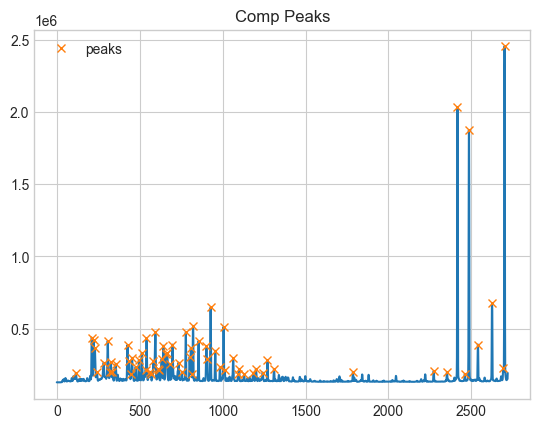

[ 115  211  222  230  242  282  307  321  326  334  355  427  435  448
  454  476  495  513  536  541  561  567  582  594  610  616  633  643
  660  666  680  697  735  754  778  801  808  814  822  855  902  907
  927  956  984 1006 1012 1064 1094 1099 1129 1184 1201 1242 1270 1310
 1786 2273 2353 2416 2460 2485 2539 2625 2693 2700]


66

In [206]:
from scipy.signal import find_peaks

peaks, _ = find_peaks(comp_spectrum_1d, height=183000)  #edit this one
plt.plot(comp_spectrum_1d)
plt.plot(peaks, comp_spectrum_1d[peaks], "x", label='peaks')
plt.legend()
plt.title("Comp Peaks")
plt.show()
print(peaks)
len(peaks)

In [207]:
import pandas as pd
column_names = ["wavelength", "start", "end", "width", "label"]
# Read the file
df = pd.read_csv('complines_fast.dat',
                      delim_whitespace=True,
                      names=column_names,
                      engine='python',
                      comment='#',
                      quotechar=' ',
                      skip_blank_lines=True, usecols=(0,1,2,3, 4))

df.to_csv('complines_readable.csv', index=False)

In [18]:
#Polynomial coefficients: [-1.68082138e-07  6.07623032e-04  8.74859881e-01  3.55690966e+03]

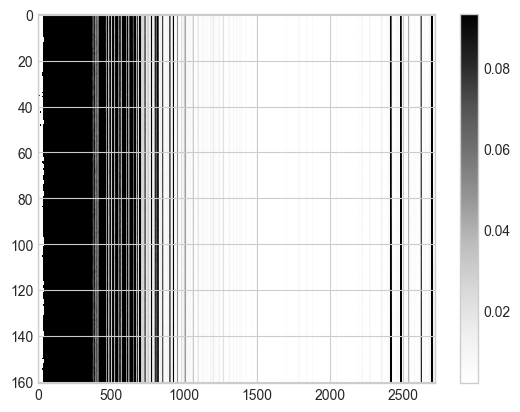

In [208]:
comp_final = (comp_data - master_bias) / master_flat

plt.imshow(comp_final, vmax = np.percentile(comp_final, 80),
          vmin = np.percentile(comp_final, 25),
          aspect = 'auto')
plt.colorbar()

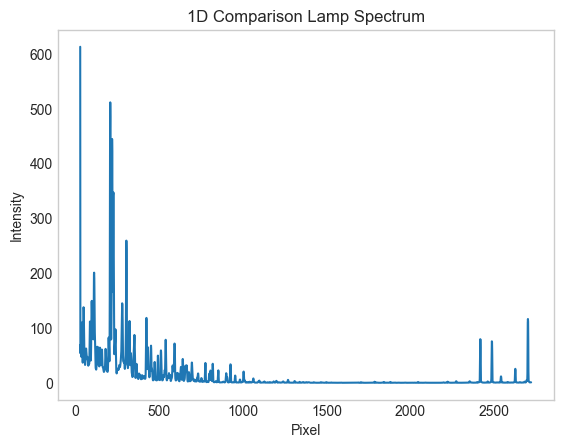

In [209]:
comp_spectrum_1d = np.sum(comp_final, axis=0)
plt.plot(comp_spectrum_1d)
plt.title('1D Comparison Lamp Spectrum')
plt.xlabel('Pixel')
plt.ylabel('Intensity')
plt.grid()
plt.show()

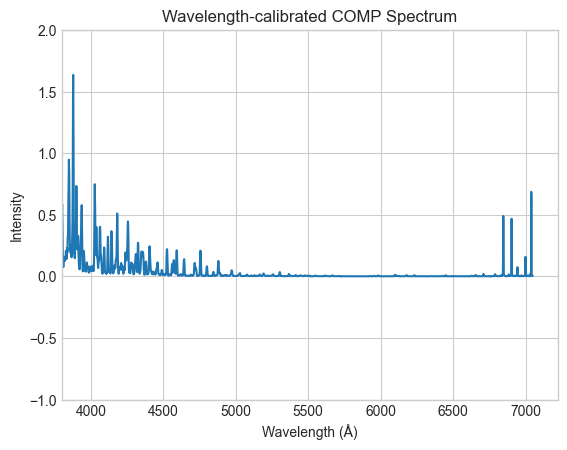

In [210]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

# Your coefficients: highest degree first
coeffs = [-1.68082138e-07, 6.07623032e-04, 8.74859881e-01, 3.55690966e+03]

# Create pixel index array
num_pixels = comp_final.shape[-1]  # Assumes dispersion axis is last
pixels = np.arange(num_pixels)

# Convert pixels to wavelengths
wavelengths = np.polyval(coeffs, pixels)

# Optional: plot COMP spectrum
plt.plot(wavelengths, comp_final[0])
plt.xlabel("Wavelength (Å)")
plt.xlim(left=3800)  
plt.ylabel("Intensity")
plt.title("Wavelength-calibrated COMP Spectrum")
plt.ylim(-1, 2)
plt.show()


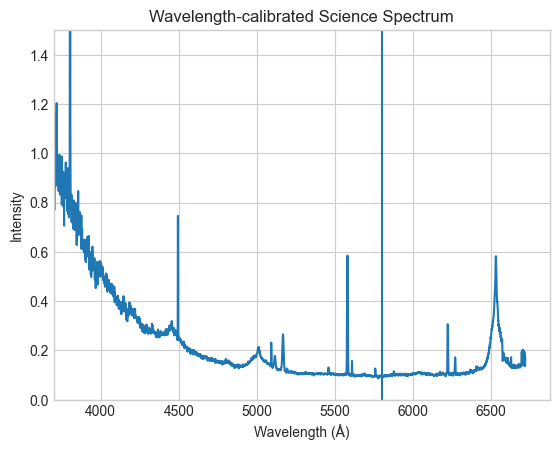

In [254]:
spectrum_1d = np.sum(final[75:88, :], axis=0)

coeffs = [-1.84582138e-07, 6.07623032e-04, 8.74859881e-01, 3.55690966e+03]

num_pixels = comp_final.shape[-1] 
pixels = np.arange(num_pixels)

wavelengths = np.polyval(coeffs, pixels)

plt.plot(wavelengths, spectrum_1d)
plt.xlabel("Wavelength (Å)")
plt.xlim(left=3700)  
plt.ylabel("Intensity")
plt.title("Wavelength-calibrated Science Spectrum")
plt.ylim(-0.0, 1.5)
plt.axvline(5799)
plt.show()

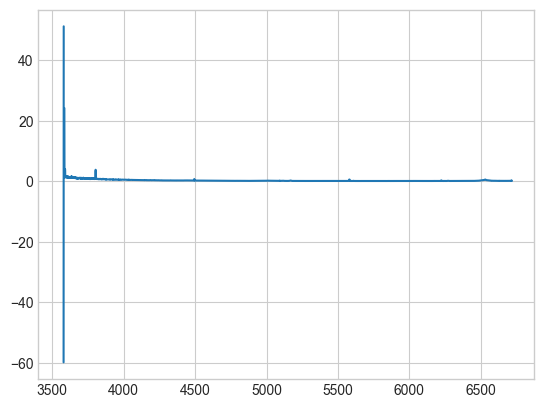

In [212]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from numpy.polynomial import Polynomial

# Create spectrum
spectrum_1d = np.sum(final[75:88, :], axis=0)
spectrum = spectrum_1d[0] if spectrum_1d.ndim > 1 else spectrum_1d
plt.plot(wavelengths, spectrum_1d)

# Optional: smooth the spectrum to help with baseline estimation
smoothed = savgol_filter(spectrum, window_length=101, polyorder=4)

Valid points: 2691 / 2720


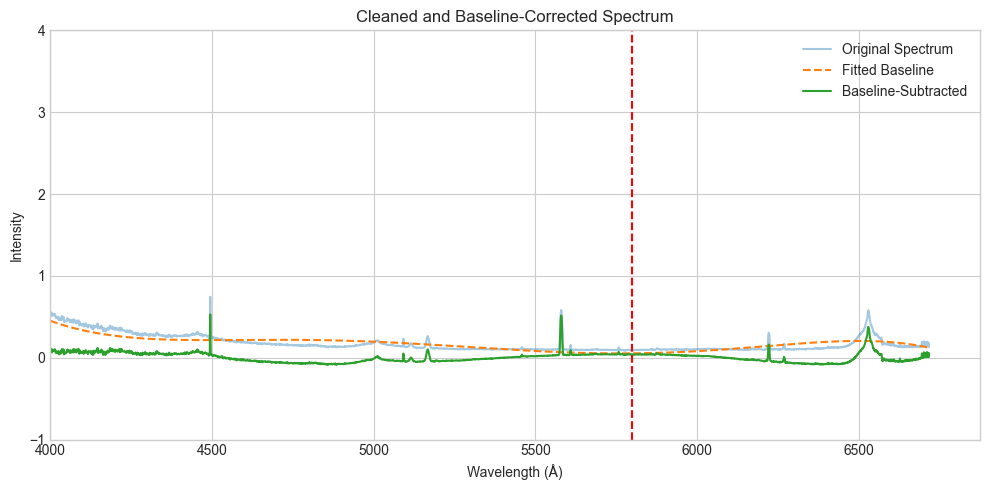

In [213]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial

# Sum over axis and flatten
spectrum_1d = np.sum(final[75:88, :], axis=0)
spectrum = spectrum_1d[0] if spectrum_1d.ndim > 1 else spectrum_1d

# Sanity check: ensure matching length
assert len(spectrum) == len(wavelengths), "Mismatch in length between spectrum and wavelengths"

# Clean the spectrum: remove inf and nan
valid_mask = np.isfinite(spectrum) & np.isfinite(wavelengths)
clean_wavelengths = wavelengths[valid_mask]
clean_spectrum = spectrum[valid_mask]

# Optional: print how many points we're keeping
print(f"Valid points: {np.sum(valid_mask)} / {len(spectrum)}")

# Fit a polynomial baseline
fit = Polynomial.fit(clean_wavelengths, clean_spectrum, deg=5)
baseline = fit(clean_wavelengths)

# Subtract the baseline
flattened = clean_spectrum - baseline

# Plot
plt.figure(figsize=(10, 5))
plt.plot(clean_wavelengths, clean_spectrum, label="Original Spectrum", alpha=0.4)
plt.plot(clean_wavelengths, baseline, label="Fitted Baseline", linestyle='--')
plt.plot(clean_wavelengths, flattened, label="Baseline-Subtracted", linewidth=1.5)
plt.axvline(5799, color='red', linestyle='--')
plt.xlabel("Wavelength (Å)")
plt.ylabel("Intensity")
plt.title("Cleaned and Baseline-Corrected Spectrum")
plt.legend()
plt.ylim(-1, 4)
plt.xlim(left=4000)
plt.grid(True)
plt.tight_layout()
plt.show()


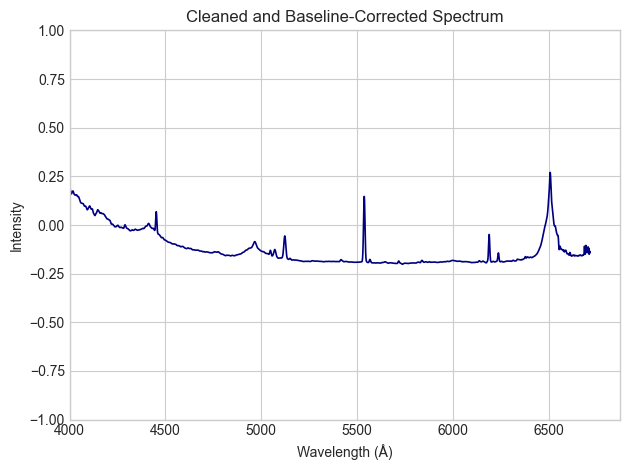

In [255]:
from scipy.ndimage import gaussian_filter1d
smoothed = gaussian_filter1d(flattened, sigma=2)  # Try sigma=1–3

normalized = (smoothed - np.min(smoothed)) / (np.max(smoothed) - np.min(smoothed))

min_len = min(len(wavelengths), len(smoothed))
plt.plot(wavelengths[:min_len], smoothed[:min_len], linewidth=1.2, color='navy')
plt.xlabel("Wavelength (Å)")
plt.ylabel("Intensity")
plt.title("Cleaned and Baseline-Corrected Spectrum")
plt.legend()
plt.ylim(-1, 1)
plt.xlim(left=4000)
plt.grid(True)
plt.tight_layout()
plt.show()



2120
2120
Estimated V-band flux: 3.60e-15 erg/s/cm^2/Å


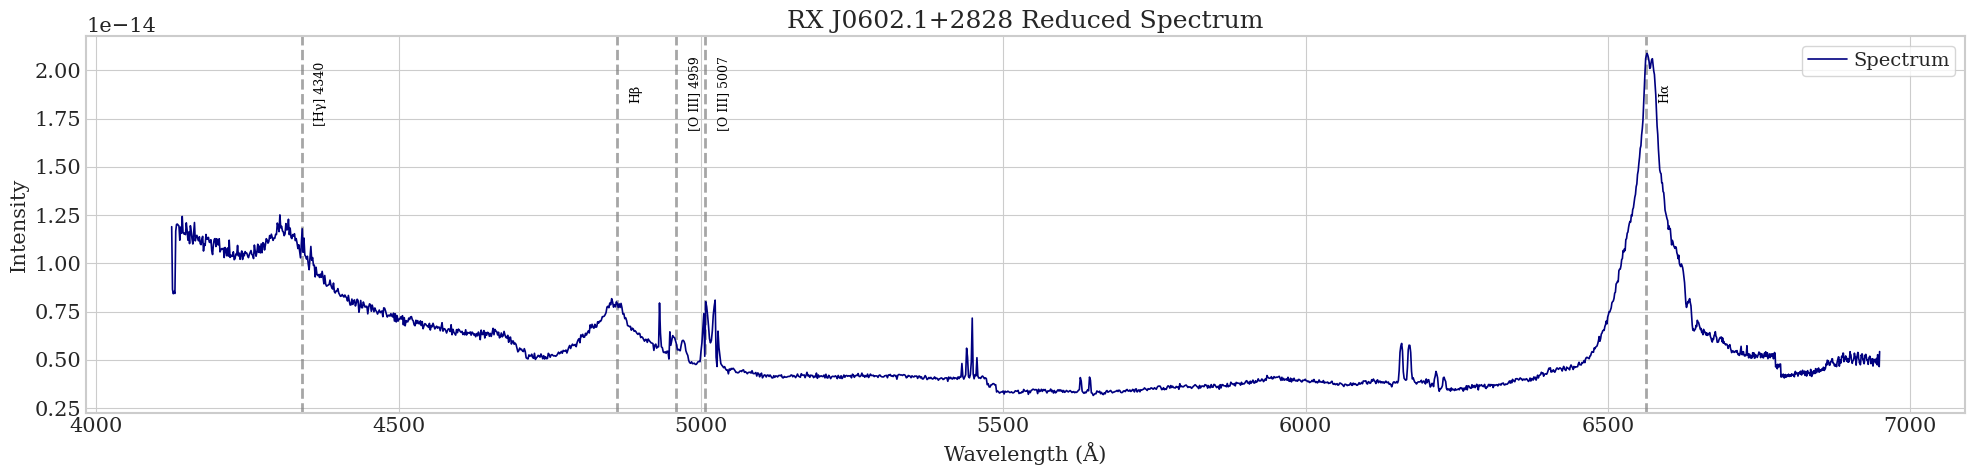

In [354]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d


coeffs = [-1.60582138e-07, 6.27623032e-04, 8.00859881e-01, 3.58890966e+03]

num_pixels = comp_final.shape[-1] 
pixels = np.arange(num_pixels)

wavelengths = np.polyval(coeffs, pixels)
cutoff = 600
trimmed_wavelengths = wavelengths[cutoff:]
trimmed_spectrum = spectrum_1d_cropped[:]
print(len(trimmed_spectrum))
print(len(trimmed_wavelengths))

threshold = 0.5

cleaned_spectrum = trimmed_spectrum.copy()

for i in range(1, len(trimmed_spectrum) - 5):
    left = trimmed_spectrum[i - 5]
    center = trimmed_spectrum[i]
    right = trimmed_spectrum[i + 5]
    
    if center > threshold * max(left, right):
        cleaned_spectrum[i] = (left + right) / 2 

smoothed = gaussian_filter1d(cleaned_spectrum, sigma=1)

normalized = (smoothed - np.min(smoothed)) / (np.max(smoothed) - np.min(smoothed))

lines = {
    'Hβ': 4861,
    'Hα': 6563,
    '[O III] 4959': 4959,
    '[O III] 5007': 5007,
    '[Hγ] 4340': 4340
}

z = 0.033

# observed_lines = {name: wl * (1 + z) for name, wl in lines.items()}

resting_lines = {name: wl for name, wl in lines.items()}


rest_wavelengths = trimmed_wavelengths / (1 + z)


# Given V-band magnitude
V_mag = 15

# V-band zero point in erg/s/cm^2/Å at ~5500 Å (approximate)
F0_V = 3.6e-9  # erg/s/cm^2/Å

# Compute flux
F_V = F0_V * 10**(-0.4 * V_mag)
print(f"Estimated V-band flux: {F_V:.2e} erg/s/cm^2/Å")



# Find flux in your spectrum around 5500 Å
idx_near_5500 = np.where((rest_wavelengths > 5450) & (rest_wavelengths < 5550))[0]
mean_counts_5500 = np.mean(cleaned_spectrum[idx_near_5500])

# Scaling factor to match V-band flux
scaling_factor = F_V / mean_counts_5500

# Convert to flux-calibrated spectrum
flux_spectrum = cleaned_spectrum * scaling_factor



plt.figure(figsize=(20, 5))

for name, obs_wl in resting_lines.items():
    plt.axvline(obs_wl, color='grey', linestyle='--', alpha=0.7)
    plt.text(obs_wl + 20, max(flux_spectrum) * 0.9, name, rotation=90,
             verticalalignment='center', fontsize=9, color='black')
#plt.plot(trimmed_wavelengths, trimmed_spectrum, label="Original Trimmed", alpha=0.4, color='gray')
plt.plot(rest_wavelengths, flux_spectrum, label="Spectrum", color='navy', linewidth=1.2)
plt.xlabel("Wavelength (Å)")
plt.ylabel("Intensity")
plt.title("RX J0602.1+2828 Reduced Spectrum")
plt.legend()
plt.tight_layout()

plt.rcParams['legend.frameon'] = True
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.labelspacing'] = 0.3
plt.rcParams['legend.handletextpad'] = 0.3
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'DejaVu Serif'
plt.rcParams['font.weight'] = 'light'
plt.rcParams['font.size'] = 15
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.width'] = 2
plt.rcParams["axes.linewidth"] = 1.5
plt.show()




In [256]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial
from scipy.ndimage import gaussian_filter1d

# Sum over rows (example: 75 to 88)
# spectrum_1d = np.sum(final[75:88, :], axis=0)
spectrum = spectrum_1d_cropped[0] if spectrum_1d_cropped.ndim > 1 else spectrum_1d_cropped

# Sanity check
assert len(spectrum) == len(wavelengths), "Mismatch in length between spectrum and wavelengths"

# Remove invalid points
valid_mask = np.isfinite(spectrum) & np.isfinite(wavelengths)
clean_wavelengths = wavelengths[valid_mask]
clean_spectrum = spectrum[valid_mask]
print(f"Valid points: {np.sum(valid_mask)} / {len(spectrum)}")

# Baseline fitting
fit = Polynomial.fit(clean_wavelengths, clean_spectrum, deg=0)
baseline = fit(clean_wavelengths)
flattened = clean_spectrum - baseline

# Smoothing
smoothed = gaussian_filter1d(flattened, sigma=2)

# Normalization
normalized = (smoothed - np.min(smoothed)) / (np.max(smoothed) - np.min(smoothed))

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(clean_wavelengths, clean_spectrum, label="Original", alpha=0.3)
plt.plot(clean_wavelengths, baseline, label="Baseline", linestyle='--')
plt.plot(clean_wavelengths, flattened, label="Flattened", alpha=0.5)
plt.plot(clean_wavelengths, smoothed, label="Smoothed", linewidth=1.5)
plt.plot(clean_wavelengths, normalized, label="Normalized", linewidth=1.5, color='black', alpha=0.7)
plt.axvline(5799, color='red', linestyle='--', label='Reference Line')
plt.xlabel("Wavelength (Å)")
plt.ylabel("Intensity")
plt.title("Cleaned, Flattened, and Smoothed Spectrum")
plt.ylim(-1, 4)
plt.xlim(left=4000)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


AssertionError: Mismatch in length between spectrum and wavelengths

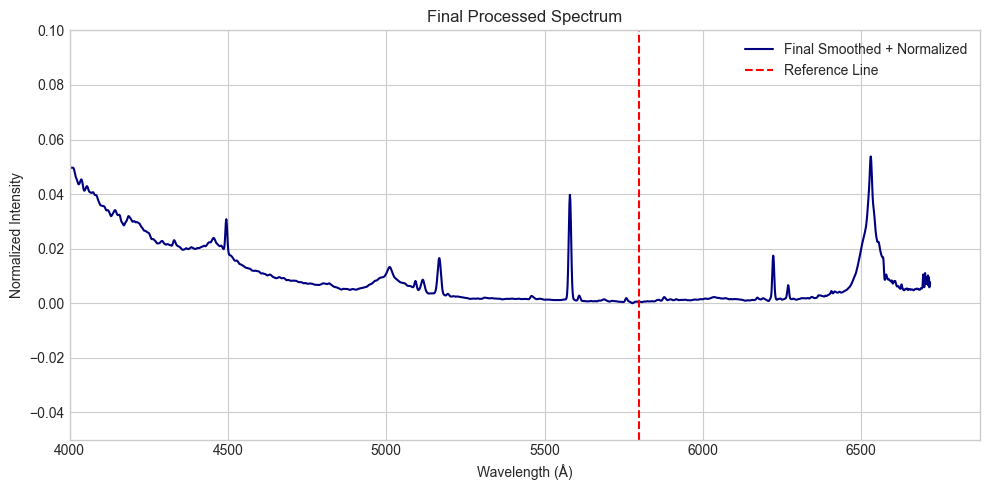

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial
from scipy.ndimage import gaussian_filter1d

# Sum over selected rows
spectrum_1d = np.sum(final[75:88, :], axis=0)
spectrum = spectrum_1d[0] if spectrum_1d.ndim > 1 else spectrum_1d

# Clean NaNs/Infs
valid_mask = np.isfinite(spectrum) & np.isfinite(wavelengths)
clean_wavelengths = wavelengths[valid_mask]
clean_spectrum = spectrum[valid_mask]

# Fit and subtract polynomial baseline
fit = Polynomial.fit(clean_wavelengths, clean_spectrum, deg=)
baseline = fit(clean_wavelengths)
flattened = clean_spectrum - baseline

# Smooth the result
smoothed = gaussian_filter1d(flattened, sigma=2)

# Normalize
normalized = (smoothed - np.min(smoothed)) / (np.max(smoothed) - np.min(smoothed))

# Plot only the final result
plt.figure(figsize=(10, 5))
plt.plot(clean_wavelengths, normalized, color='navy', linewidth=1.5, label='Final Smoothed + Normalized')
plt.axvline(5799, color='red', linestyle='--', label='Reference Line')
plt.xlabel("Wavelength (Å)")
plt.ylabel("Normalized Intensity")
plt.title("Final Processed Spectrum")
plt.ylim(-.05, .1)
plt.xlim(left=4000)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


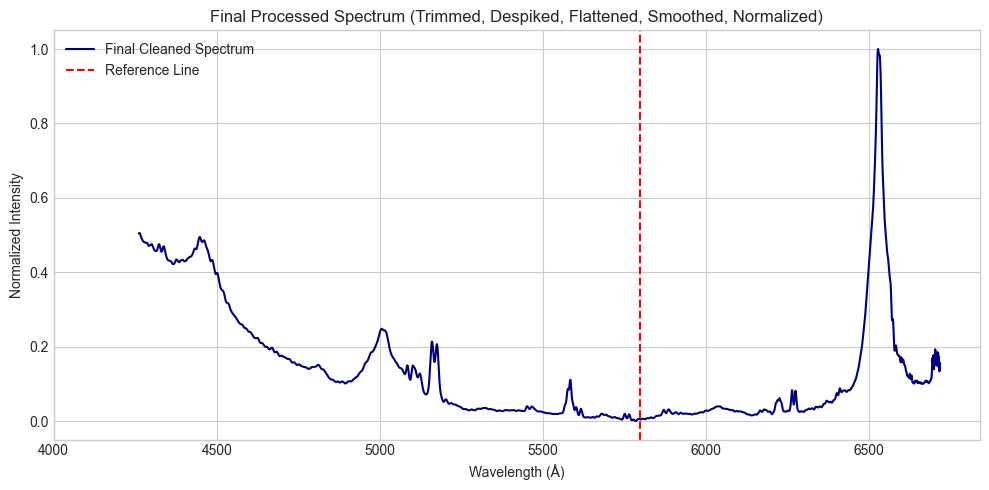

In [229]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial
from scipy.ndimage import gaussian_filter1d

# Step 1: Collapse spectrum along spatial axis
spectrum_1d = np.sum(final[75:88, :], axis=0)
spectrum = spectrum_1d[0] if spectrum_1d.ndim > 1 else spectrum_1d

# Step 2: Trim noisy start
cutoff = 600
trimmed_wavelengths = wavelengths[cutoff:]
trimmed_spectrum = spectrum[cutoff:]

# Step 3: Spike removal
threshold = 0.5  # Ratio threshold
cleaned_spectrum = trimmed_spectrum.copy()
for i in range(5, len(trimmed_spectrum) - 5):
    left = trimmed_spectrum[i - 5]
    center = trimmed_spectrum[i]
    right = trimmed_spectrum[i + 5]
    if center > threshold * max(left, right):
        cleaned_spectrum[i] = (left + right) / 2

# Step 4: Remove NaN/Inf
valid_mask = np.isfinite(cleaned_spectrum) & np.isfinite(trimmed_wavelengths)
clean_wavelengths = trimmed_wavelengths[valid_mask]
clean_spectrum = cleaned_spectrum[valid_mask]

# Step 5: Polynomial baseline fitting
fit = Polynomial.fit(clean_wavelengths, clean_spectrum, deg=0)
baseline = fit(clean_wavelengths)
flattened = clean_spectrum - baseline

# Step 6: Smoothing
smoothed = gaussian_filter1d(flattened, sigma=2)

# Step 7: Normalization
normalized = (smoothed - np.min(smoothed)) / (np.max(smoothed) - np.min(smoothed))

# Step 8: Final plot
plt.figure(figsize=(10, 5))
plt.plot(clean_wavelengths, normalized, color='navy', linewidth=1.5, label='Final Cleaned Spectrum')
plt.axvline(5799, color='red', linestyle='--', label='Reference Line')
plt.xlabel("Wavelength (Å)")
plt.ylabel("Normalized Intensity")
plt.title("Final Processed Spectrum (Trimmed, Despiked, Flattened, Smoothed, Normalized)")
plt.ylim(-0.05, 1.05)
plt.xlim(left=4000)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


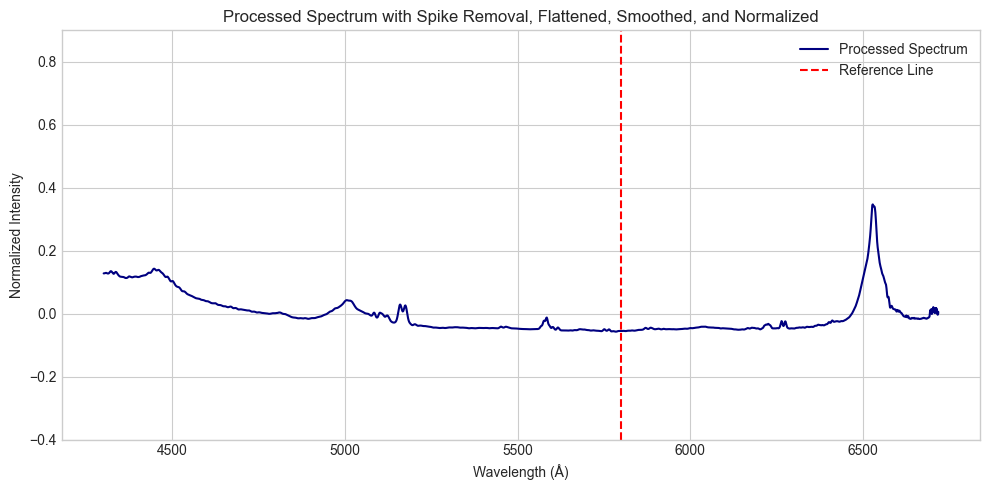

In [230]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial
from scipy.ndimage import gaussian_filter1d

spectrum_1d = np.sum(final[75:88, :], axis=0)
spectrum = spectrum_1d[0] if spectrum_1d.ndim > 1 else spectrum_1d

valid_mask = np.isfinite(spectrum) & np.isfinite(wavelengths)
clean_wavelengths = wavelengths[valid_mask]
clean_spectrum = spectrum[valid_mask]

cutoff = 600  # Cutoff to remove early noisy section
trimmed_wavelengths = clean_wavelengths[cutoff:]
trimmed_spectrum = clean_spectrum[cutoff:]

# Define spike threshold (ratio of neighbors to center)
threshold = 0.5
cleaned_spectrum = trimmed_spectrum.copy()

for i in range(5, len(trimmed_spectrum) - 5):
    left = trimmed_spectrum[i - 5]
    center = trimmed_spectrum[i]
    right = trimmed_spectrum[i + 5]
    
    if center > threshold * max(left, right):
        cleaned_spectrum[i] = (left + right) / 2  # Replace with average of neighbors

fit = Polynomial.fit(trimmed_wavelengths, cleaned_spectrum, deg=0)
baseline = fit(trimmed_wavelengths)
flattened = cleaned_spectrum - baseline

smoothed = gaussian_filter1d(flattened, sigma=2)

#normalized = (smoothed - np.min(smoothed)) / (np.max(smoothed) - np.min(smoothed))

plt.figure(figsize=(10, 5))
plt.plot(trimmed_wavelengths, smoothed, color='navy', linewidth=1.5, label='Processed Spectrum')
plt.axvline(5799, color='red', linestyle='--', label='Reference Line')
plt.xlabel("Wavelength (Å)")
plt.ylabel("Normalized Intensity")
plt.title("Processed Spectrum with Spike Removal, Flattened, Smoothed, and Normalized")
plt.legend()
plt.ylim((-0.4,.9))
plt.grid(True)
plt.tight_layout()
plt.show()


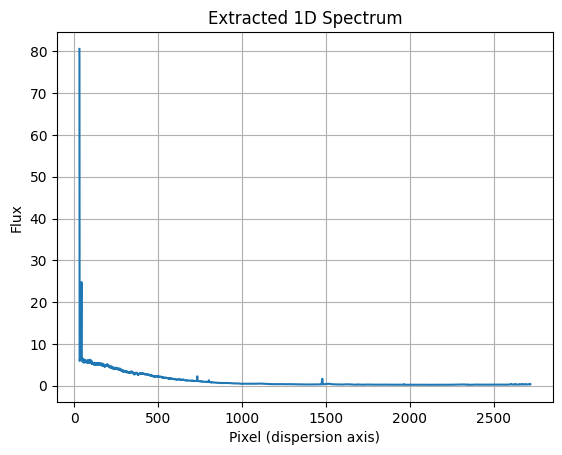

In [62]:
# Step 2: Collapse the spectrum over the bright rows to get a 1D spectrum
lower_bound = 65  # update after checking the plot
upper_bound = 90

# Extract only the rows with the spectral signal
spectrum_2d = final[lower_bound:upper_bound, :]

# Sum along the spatial axis (vertical) to get the 1D spectrum
spectrum_1d = np.sum(spectrum_2d, axis=0)

# Plot the 1D spectrum
plt.plot(spectrum_1d)
plt.title("Extracted 1D Spectrum")
plt.xlabel("Pixel (dispersion axis)")
plt.ylabel("Flux")
plt.grid()
plt.show()

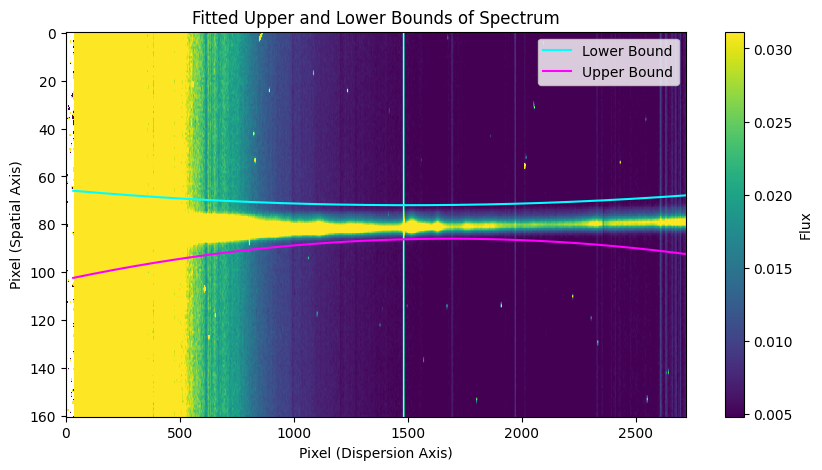

In [63]:
from scipy.ndimage import gaussian_filter1d

upper_edges = []
lower_edges = []

# Control how wide the search is
threshold_percentile = 90

for x in range(final.shape[1]):
    col = final[:, x]
    
    # Smooth column to reduce noise
    smooth_col = gaussian_filter1d(col, sigma=2)

    # Threshold to find where the spectrum starts and ends
    threshold = np.percentile(smooth_col, threshold_percentile)
    
    bright_indices = np.where(smooth_col > threshold)[0]
    
    if len(bright_indices) > 0:
        lower_edges.append(bright_indices[0])        # first bright pixel (top of spectrum)
        upper_edges.append(bright_indices[-1])       # last bright pixel (bottom of spectrum)
    else:
        lower_edges.append(np.nan)
        upper_edges.append(np.nan)

x_vals = np.arange(len(lower_edges))
valid = ~np.isnan(lower_edges)
x_fit = x_vals[valid]

# Fit polynomials to top and bottom edge
lower_fit = np.poly1d(np.polyfit(x_fit, np.array(lower_edges)[valid], deg=2))
upper_fit = np.poly1d(np.polyfit(x_fit, np.array(upper_edges)[valid], deg=2))

# Plot the image and overlay the boundaries
plt.figure(figsize=(10, 5))
plt.imshow(final, aspect='auto', cmap='viridis',
           vmin=np.percentile(final, 25), vmax=np.percentile(final, 80))
plt.plot(x_fit, lower_fit(x_fit), color='cyan', label='Lower Bound')
plt.plot(x_fit, upper_fit(x_fit), color='magenta', label='Upper Bound')
plt.legend()
plt.title("Fitted Upper and Lower Bounds of Spectrum")
plt.xlabel("Pixel (Dispersion Axis)")
plt.ylabel("Pixel (Spatial Axis)")
plt.colorbar(label='Flux')
plt.show()

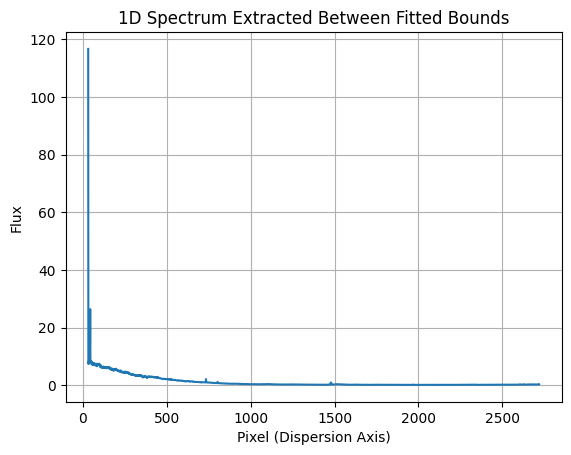

In [64]:
spectrum_1d = []

for x in range(final.shape[1]):
    y_low = int(lower_fit(x))
    y_high = int(upper_fit(x))
    if 0 <= y_low < y_high <= final.shape[0]:
        spectrum_1d.append(np.sum(final[y_low:y_high, x]))
    else:
        spectrum_1d.append(0)

spectrum_1d = np.array(spectrum_1d)

plt.plot(spectrum_1d)
plt.title("1D Spectrum Extracted Between Fitted Bounds")
plt.xlabel("Pixel (Dispersion Axis)")
plt.ylabel("Flux")
plt.grid()
plt.show()

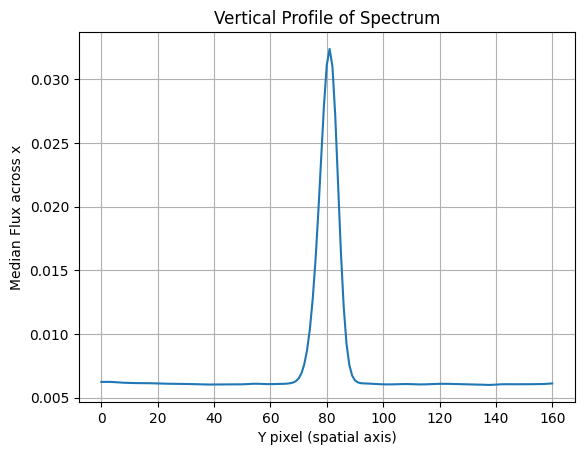

In [65]:
# Collapse along x to get a 1D spatial profile (median to suppress outliers)
spatial_profile = np.median(final, axis=1)

# Smooth it a bit to suppress noise
from scipy.ndimage import gaussian_filter1d
smoothed_profile = gaussian_filter1d(spatial_profile, sigma=2)

# Plot it to visualize
plt.plot(smoothed_profile)
plt.xlabel("Y pixel (spatial axis)")
plt.ylabel("Median Flux across x")
plt.title("Vertical Profile of Spectrum")
plt.grid()
plt.show()

In [66]:
# Use a percentile-based threshold to detect faint glow
threshold = np.percentile(smoothed_profile, 90)

# Get the y-indices where the flux exceeds threshold
bright_region = np.where(smoothed_profile > threshold)[0]

# Define upper and lower bounds
y_lower = bright_region[0]
y_upper = bright_region[-1]

print(f"Lower bound (top of trace): {y_lower}")
print(f"Upper bound (bottom of trace): {y_upper}")

Lower bound (top of trace): 72
Upper bound (bottom of trace): 87


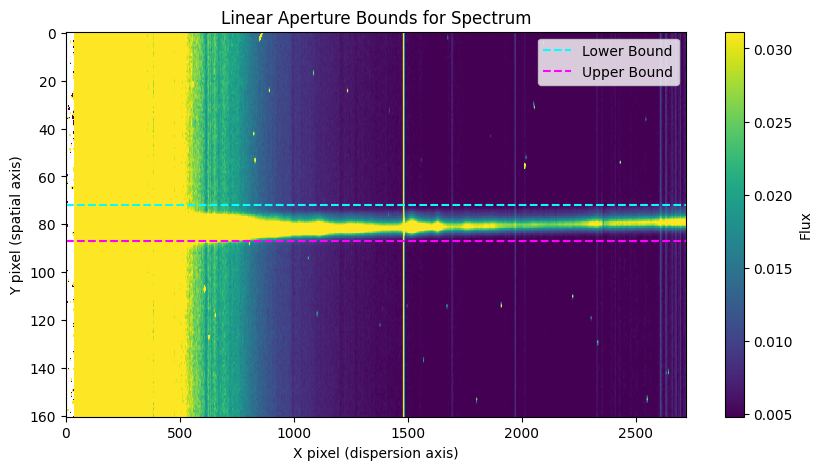

In [67]:
plt.figure(figsize=(10, 5))
plt.imshow(final, aspect='auto', cmap='viridis',
           vmin=np.percentile(final, 25), vmax=np.percentile(final, 80))
plt.axhline(y_lower, color='cyan', linestyle='--', label='Lower Bound')
plt.axhline(y_upper, color='magenta', linestyle='--', label='Upper Bound')
plt.legend()
plt.title("Linear Aperture Bounds for Spectrum")
plt.xlabel("X pixel (dispersion axis)")
plt.ylabel("Y pixel (spatial axis)")
plt.colorbar(label='Flux')
plt.show()

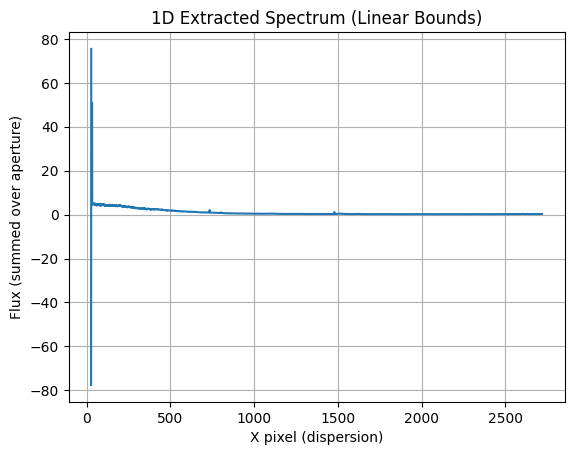

In [68]:
# Sum over the vertical region (between y_lower and y_upper) for each column
spectrum_1d = np.sum(final[y_lower:y_upper+1, :], axis=0)

# Plot 1D spectrum
plt.plot(spectrum_1d)
plt.title("1D Extracted Spectrum (Linear Bounds)")
plt.xlabel("X pixel (dispersion)")
plt.ylabel("Flux (summed over aperture)")
plt.grid()
plt.show()

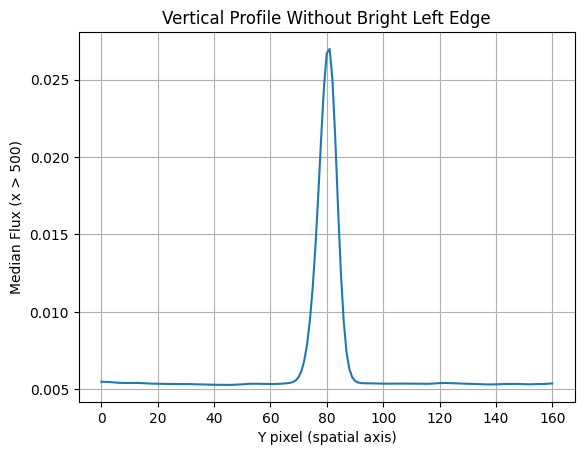

In [69]:
# Crop final image to exclude first 500 columns
final_cropped = final[:, 500:]  # remove overly bright region

# Compute spatial profile (vertical trace), now only using relevant columns
spatial_profile = np.median(final_cropped, axis=1)

# Smooth to reduce noise
from scipy.ndimage import gaussian_filter1d
smoothed_profile = gaussian_filter1d(spatial_profile, sigma=2)

# Visualize
plt.plot(smoothed_profile)
plt.xlabel("Y pixel (spatial axis)")
plt.ylabel("Median Flux (x > 500)")
plt.title("Vertical Profile Without Bright Left Edge")
plt.grid()
plt.show()

In [70]:
# Choose a reasonable threshold (90th percentile works well)
threshold = np.percentile(smoothed_profile, 90)

# Get y-positions of the bright horizontal trace
bright_region = np.where(smoothed_profile > threshold)[0]

# Define straight-line bounds
y_lower = bright_region[0]
y_upper = bright_region[-1]

print(f"Lower bound (top of trace): {y_lower}")
print(f"Upper bound (bottom of trace): {y_upper}")


Lower bound (top of trace): 72
Upper bound (bottom of trace): 87


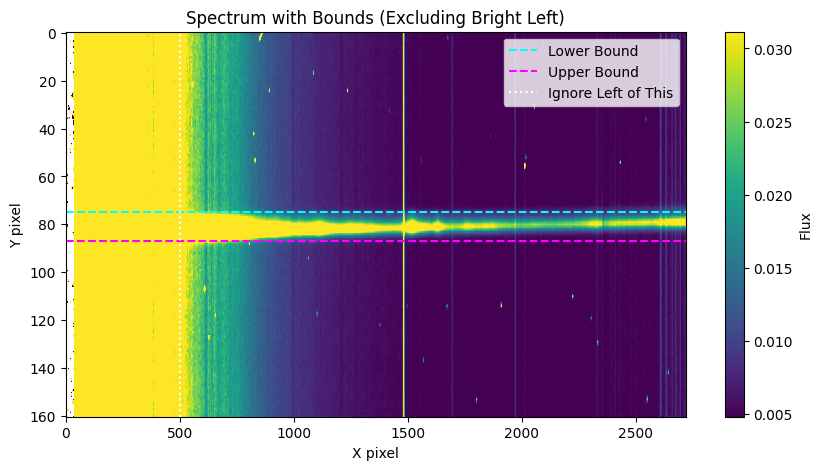

In [76]:
plt.figure(figsize=(10, 5))
plt.imshow(final, aspect='auto', cmap='viridis',
           vmin=np.percentile(final, 25), vmax=np.percentile(final, 80))
plt.axhline(y_lower+3, color='cyan', linestyle='--', label='Lower Bound')
plt.axhline(y_upper, color='magenta', linestyle='--', label='Upper Bound')
plt.axvline(500, color='white', linestyle=':', label='Ignore Left of This')
plt.legend()
plt.title("Spectrum with Bounds (Excluding Bright Left)")
plt.xlabel("X pixel")
plt.ylabel("Y pixel")
plt.colorbar(label='Flux')
plt.show()


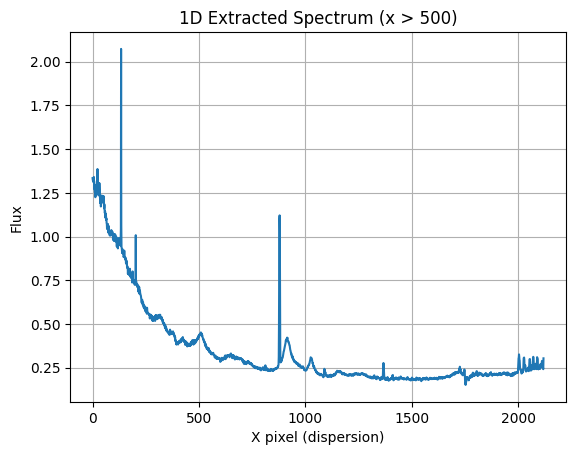

In [75]:
# Full width extraction
spectrum_1d = np.sum(final[y_lower+3:y_upper+1, :], axis=0)

# Or restrict to x > 500 only
spectrum_1d_cropped = np.sum(final[y_lower:y_upper+1, 600:], axis=0)

# Plot cropped spectrum
plt.plot(spectrum_1d_cropped)
plt.title("1D Extracted Spectrum (x > 500)")
plt.xlabel("X pixel (dispersion)")
plt.ylabel("Flux")
plt.grid()
plt.show()


In [47]:
from astropy.io import fits

hdul = fits.open(clean_path)
print(f"Number of HDUs: {len(hdul)}")
for i, hdu in enumerate(hdul):
    print(f"HDU {i}: {type(hdu)}")

for i, hdu in enumerate(hdul):
    print(f"\nHDU {i} header:")
    for j, card in enumerate(hdu.header.cards):
        print(f"{j}: {card}")

from astropy.io import fits

with fits.open(clean_path, mode='update') as hdul:
    header = hdul[0].header
    if 'P.I.' in header:
        del header['P.I.']
    hdul.flush()

# Re-open the cleaned FITS file and verify
with fits.open(clean_path) as hdul:
    hdul.verify('silentfix')  # Should pass now
    header = hdul[0].header
    print(header)

Number of HDUs: 1
HDU 0: <class 'astropy.io.fits.hdu.image.PrimaryHDU'>

HDU 0 header:
0: SIMPLE  =                    T / Primary FITS image array                       
1: BITPIX  =                   16                                                  
2: NAXIS   =                    2 / NUMBER OF AXES                                 
3: NAXIS1  =                 2720 / CHIP WIDTH                                     
4: NAXIS2  =                  161 / CHIP HEIGHT                                    
5: EXTEND  =                    F / Fits standard                                  
6: OBJECT  = 'OJ287             ' / OBJECT NAME                                    
7: NAMPS   =                    1                                                  
8: DATE    = '2025-03-19T04:18:47' / UT date/time at start                         
9: DATE-OBS= '2025-03-19        ' / UT date/time at start                          
10: RA      = '08:54:48.8        ' / RA                                  

SIMPLE  =                    T / Primary FITS image array                       BITPIX  =                   16                                                  NAXIS   =                    2 / NUMBER OF AXES                                 NAXIS1  =                 2720 / CHIP WIDTH                                     NAXIS2  =                  161 / CHIP HEIGHT                                    EXTEND  =                    F / Fits standard                                  OBJECT  = 'OJ287             ' / OBJECT NAME                                    NAMPS   =                    1                                                  DATE    = '2025-03-19T04:18:47' / UT date/time at start                         DATE-OBS= '2025-03-19        ' / UT date/time at start                          RA      = '08:54:48.8        ' / RA                                             DEC     = '20:06:30.639583620' / DEC                                            ROTANGLE= '085               ' / ROT ANG

In [79]:
comp_header = fits.getheader(comp_path)
print(comp_header)


SIMPLE  =                    T / Primary FITS image array                       BITPIX  =                   16                                                  NAXIS   =                    2 / NUMBER OF AXES                                 NAXIS1  =                 2720 / CHIP WIDTH                                     NAXIS2  =                  161 / CHIP HEIGHT                                    EXTEND  =                    F / Fits standard                                  OBJECT  = 'COMP              ' / OBJECT NAME                                    NAMPS   =                    1                                                  DATE    = '2025-03-19T06:58:34' / UT date/time at start                         DATE-OBS= '2025-03-19        ' / UT date/time at start                          RA      = '12:29:06.69       ' / RA                                             DEC     = '02:03:08.59       ' / DEC                                            EPOCH   = '2000              ' / EPOCH  

In [46]:
from astropy.io import fits

# Specify the path to your FITS file
comp_path = 'C:/Users/jimmy/OneDrive/Astron100/Day1/Comp/0063.COMP_3C273.fits'

p = fits.getheader(comp_path)

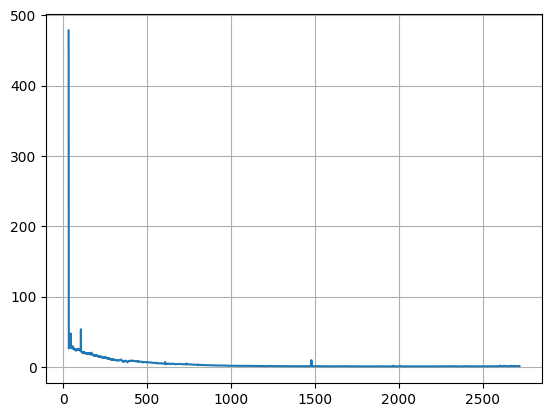

In [48]:
spectrum_1d = np.sum(final, axis=0) 
plt.plot(spectrum_1d)
plt.grid()
plt.show()

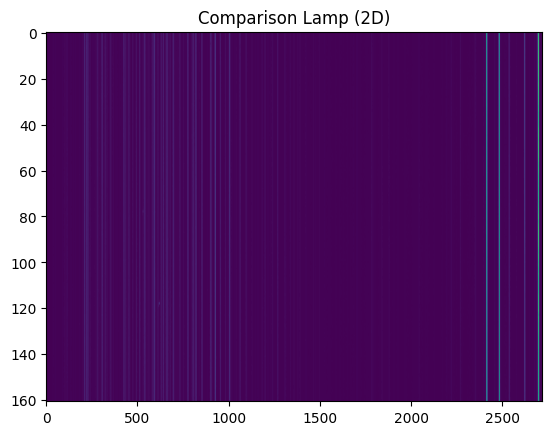

In [49]:
comp_path = 'C:/Users/jimmy/OneDrive/Astron100/Day1/Comp/0063.COMP_3C273.fits'
comp_data = fits.getdata(comp_path)

# Basic visualization
plt.imshow(comp_data, aspect='auto', cmap='viridis')
plt.title('Comparison Lamp (2D)')
plt.show()

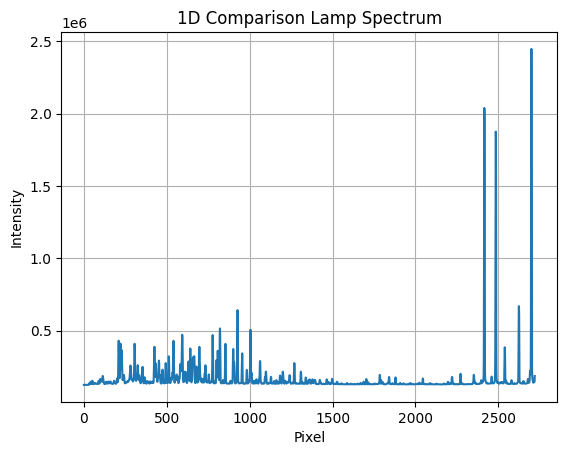

In [10]:
comp_spectrum_1d = np.sum(comp_data, axis=0)
plt.plot(comp_spectrum_1d)
plt.title('1D Comparison Lamp Spectrum')
plt.xlabel('Pixel')
plt.ylabel('Intensity')
plt.grid()
plt.show()

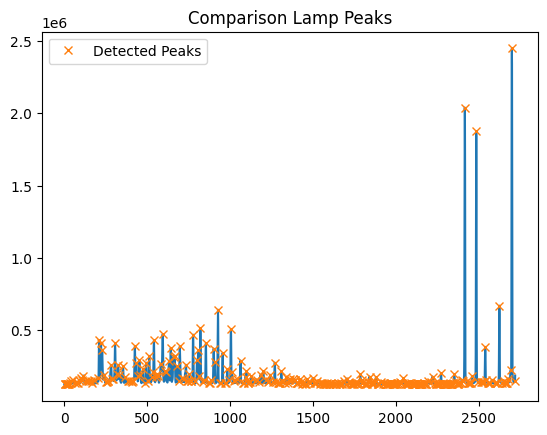

In [11]:
from scipy.signal import find_peaks

peaks, _ = find_peaks(comp_spectrum_1d, height=1000)  # tune height threshold
plt.plot(comp_spectrum_1d)
plt.plot(peaks, comp_spectrum_1d[peaks], "x", label='Detected Peaks')
plt.legend()
plt.title("Comparison Lamp Peaks")
plt.show()

In [12]:
pixel_vals = np.array([153, 278, 398])
wave_vals = np.array([5460, 5769, 6143])

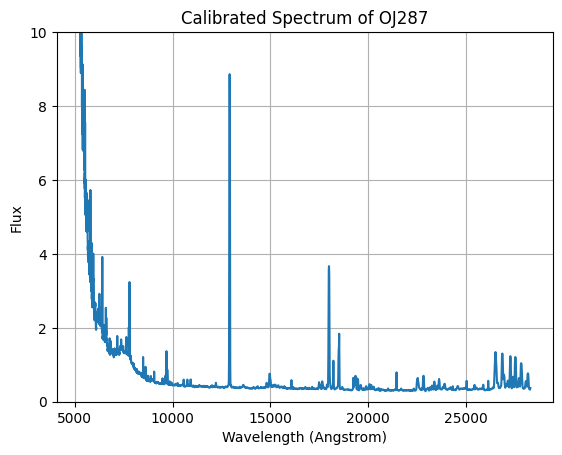

In [13]:
coeffs = np.polyfit(pixel_vals, wave_vals, deg=2)
wavelength_solution = np.poly1d(coeffs)

# Apply to the science spectrum
pixels = np.arange(len(spectrum_1d))  # from your science data
wavelength = wavelength_solution(pixels)

# Plot wavelength-calibrated spectrum
plt.plot(wavelength, spectrum_1d)
plt.xlabel("Wavelength (Angstrom)")
plt.ylabel("Flux")
plt.title("Calibrated Spectrum of OJ287")
plt.grid()
plt.ylim(0, 10)  # Set y-axis limits
plt.show()
